<h1 align="center">Fold modelling - Axial surface optimisation tutorial Part I</h1>


#### Overview

This tutorial demonstrates the use of a newly developed computational method for approximating fold axial surfaces. This section integrates algorithms proposed by Laurent et al. (2016) [Laurent et al. (2016)](https://linkinghub.elsevier.com/retrieve/pii/S0012821X16305209) with a data-driven approach from [Grose et al. (2017)](https://gmd.copernicus.org/articles/14/3915/2021/) and the geological likelihood functions of [Grose et al. (2019)](https://linkinghub.elsevier.com/retrieve/pii/S0191814118303638) to address the challenge of estimating planar fold axial surfaces in poorly outcropping regions.

#### Solving the Axial Surface Optimization Problem

The axial surface optimization problem is addressed through a multi-step computational algorithm that involves:

1. **Maximum Likelihood Estimation (MLE)**: The method uses MLE to estimate model parameters that define the axial surface: strike and dip or a 3D unit vector. MLE finds the most probable parameters (like the 3D unit vector representing the axial surface) by maximizing a likelihood function based on the observed data and/or geological knowledge.

2. **Algorithm Steps**: The algorithm proceeds through several steps, including defining geological knowledge constraints, calculating fold rotation angles, fitting Fourier series parameters to these angles, and optimizing the normal log-likelihood function to find the best axial surface representation.

3. **Incorporating Geological Knowledge**: A key aspect of this approach is the inclusion of geological knowledge constraints, such as fold tightness, asymmetry, and axial traces. These constraints are used to guide the optimization process, ensuring that the resulting model aligns with known geological principles and observations.

4. **Optimization Techniques**: The method leverages advanced optimization techniques like the Differential Evolution algorithm, which helps in navigating complex parameter spaces and ensures a robust search for the optimal axial surface. This is crucial in handling the intricacies of fold geometry and the variability in geological data.

5. **Objective Function for Geometrical Relationship**: An objective function is used to evaluate the geometrical relationship between the axial surface and the folded surface, ensuring that the model honours real-world geological structures and data.

6. **Final Solution**: The culmination of this method is a refined, data-driven, and geologically informed model of the axial surface, which is crucial for accurate fold modelling.

#### Tutorial Style Explanation

This chapter provides a step-by-step tutorial on implementing the proposed approach, from the initial problem statement to the final optimization and model evaluation. Each step is explained in detail, focusing on both the theoretical underpinnings and practical implementation, making it accessible for both academic researchers and industry professionals. Practical examples, along with algorithmic and methodological insights, guide the reader through the complexities of fold geometry modeling, demonstrating the approach's efficacy in solving real-world geological problems.
  

This tutorial will demonstrate the use of the `FourierSerieOptimiser` class, part of the FoldModellingPlugin that can be integrated into `LoopStructural`  [(Grose et al., 2021)](https://gmd.copernicus.org/articles/14/3915/2021/). This tutorial assumes you are familiar with the concepts of fold frame and fold rotation angles [(Laurent et al., 2016)](https://linkinghub.elsevier.com/retrieve/pii/S0012821X16305209) and the S-Plot  [(Grose et al., 2017)](https://linkinghub.elsevier.com/retrieve/pii/S0191814117301864) as well as the basic use of LoopStructural for fold modelling. In case you are not familiar with these concepts, it is recommended to do the following tutorials before moving forward with this tutorial: [LoopStructural fold modelling Examples](https://github.com/Loop3D/LoopStructural/tree/master/examples/2_fold).

In [1]:
from misc_functions import sample_random_dataset
from FoldOptLib.FoldOptLib.optimisers import AxialSurfaceOptimiser as ASO
from FoldOptLib.FoldOptLib.optimisers import FourierSeriesOptimiser as FSO
from FoldOptLib.FoldOptLib.helper.utils import create_fold_frame_dataset, create_dataset, clean_knowledge_dict
from LoopStructural import GeologicalModel
from LoopStructural.modelling.features.fold import FoldEvent
# from LoopStructural.visualisation import LavaVuModelViewer
# from custom_model_visualisation import LavaVuModelViewer
from LoopStructural.visualisation import MapView
from LoopStructural.visualisation import RotationAnglePlotter
from LoopStructural.modelling.features.fold import FoldRotationAngle, SVariogram
from LoopStructural.modelling.features import StructuralFrame, GeologicalFeature
from LoopStructural.modelling.features.fold import fourier_series
from LoopStructural.utils.helper import create_surface, create_box, get_data_bounding_box, normal_vector_to_strike_and_dip, plunge_and_plunge_dir_to_vector
import os
import time
import numpy as np
import pandas as pd
from scipy.optimize import least_squares
import seaborn as sns 
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.neighbors import NearestNeighbors
from IPython.display import display, clear_output
import ipywidgets as widgets
from ipywidgets import IntProgress, interact, interactive

ERROR: 2023-10-26 11:08:50,046: __init__.py:21 -- Cannot use sphinx scraper, pip install -r docs/requirements.txt
ERROR: 2023-10-26 11:08:50,050: __init__.py:25 -- Missing lavavu, can't import LavaVuModelViewer


# I. Creation of a synthetic model  

Like the Fourier series tutorial, we will start by creating a synthetic model. The synthetic model is the reference from within which we will sample data points that will be used to infer the axial surface.  

1. Define model bounding box

In [2]:
# define the maximum value of xyz model box boundaries
xmin, ymin, zmin = 0, 0, 0
xmax, ymax, zmax = 1000, 1000, 1000

bounding_box = np.array([[xmin, ymin, zmin],
               [xmax, ymax, zmax]])

2. Initialise a geological model 

In [3]:
# initiliase geological model by initialising GeologicalModel class
model = GeologicalModel(bounding_box[0, :], 
                        bounding_box[1, :])

3. Build a fold frame

In [4]:
# Create a dataset for s1 to build a fold frame 
dataset, xyz = create_fold_frame_dataset(model, strike=0, dip=90)
# add data to the initiliased geological model
model.data = dataset

In [5]:
# build the s1 fold frame
s1 = model.create_and_add_fold_frame('s1',
                                          buffer=0.3,
                                          solver='cg',
                                          nelements=2e4,
                                        damp=True)
model.update()

  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:09:23,161: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


In [6]:
# # 3D displaying the s1 fold frame
# # import lavavu
# viewer = LavaVuModelViewer(model, background='white')
# viewer.add_isosurface(s1[0], colour='red')
# viewer.add_isosurface(s1[1], colour='blue')
# viewer.add_data(s1[0], disks=False, vectors=True, colour='red')
# viewer.add_data(s1[1], disks=False, vectors=True, colour='blue')
# # t = viewer.add_scalar_field(s1[0], cmap='prism')
# # viewer.lv.colourbar(t, align=("bottom"))
# viewer.lv.rotate([-63.015506744384766, -24.475210189819336, -8.501092910766602])
# viewer.display()
# viewer.interactive()

4. Define the fold limb rotation angle profile

In [7]:
def fold_limb_rotation_profile(c0, c1, c2, wl):

    theta = [c0, c1, c2, wl]
    x = np.linspace(s1[0].min(), s1[0].max(), 100)
    flr = np.rad2deg(np.arctan(fourier_series(x, *theta)))
    fold_limb_rotation = FoldRotationAngle(flr, x) 
    fold_limb_rotation.fitted_params = theta
    fold_limb_rotation.set_function(lambda x: np.rad2deg(
                    np.arctan(fourier_series(x, *theta))))
    plt.ylim(-90, 90)
    plt.xlabel('Fold Axial Surface Field')
    plt.ylabel('Fold Limb Rotation Angle')
    plt.title('Fold Limb S-Plot')
    plt.plot(x, flr)
    plt.show()
    
    return fold_limb_rotation

def define_fold_axis_orientation(plunge_direction, plunge): 
    
    fold_axis = plunge_and_plunge_dir_to_vector(plunge, plunge_direction)
    
    return fold_axis

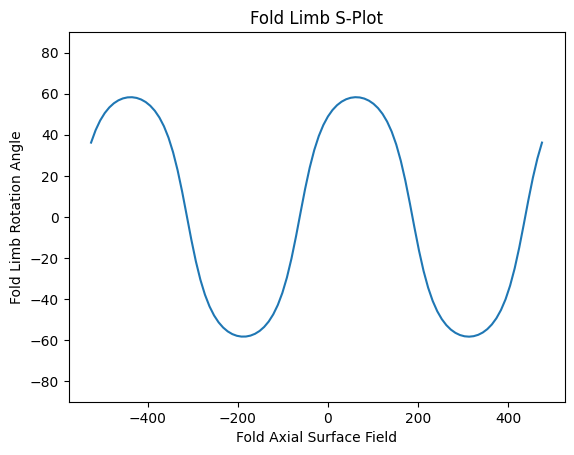

In [8]:
theta = [0, 2e-2, 2e-2, 500]
fold_limb_rotation = fold_limb_rotation_profile(*theta)

5. Calculate the normal vectors to the folded foliation



In [9]:
plunge_direction = 0
plunge = 0
fold_axis = define_fold_axis_orientation(plunge_direction, plunge)
fold = FoldEvent(s1, fold_limb_rotation=fold_limb_rotation)
fold.fold_axis = fold_axis 
fold_direction, fold_axis, dgz = fold.get_deformed_orientation(xyz)
dgx = s1[0].evaluate_gradient(xyz)
dgx /= np.linalg.norm(dgx, axis=1)[:, None]
# make sure fold direction vectors are normalised
fold_direction /= np.linalg.norm(fold_direction, axis=1)[:, None]
# calculate the dot product of the s1 and the fold direction
dot = np.einsum('ij,ij->i', dgx, fold_direction)
# correct the orientation of the fold direction vectors to be consistent
# with the direction of the axial surface 
fold_direction[dot<0] *= -1
# calculate the normal vectors of the folded foliation 
# which are the cross product of the fold axis and 
# the fold direction vectors
s0n = np.cross(fold_axis, fold_direction)
# normalise s0 normal vectors
s0n /= np.linalg.norm(s0n, axis=1)[:, None]

6. Create a dataset for s0

In [10]:
dataset = pd.DataFrame()
dataset['X'] = xyz[:, 0]
dataset['Y'] = xyz[:, 1]
dataset['Z'] = xyz[:, 2]
dataset['gx'] = s0n[:, 0]
dataset['gy'] = s0n[:, 1]
dataset['gz'] = s0n[:, 2]
dataset['feature_name'] = 's0'
dataset['coord'] = 0

7. Build a 3D model of s0

In [11]:
fold_function = fold_limb_rotation.fold_rotation_function
model.data = dataset.sample(frac=0.2)
s0 = model.create_and_add_folded_foliation('s0',
                                           fold_frame=s1,
                                            # limb_wl=500,
                                            av_fold_axis=True,
                                            limb_function=fold_function,
                                            nelements=1e5,
                                            solver='cg',
                                            buffer=0.3,
                                            damp=True)
model.update()
# s0.fold.fold_limb_rotation.fitted_params = theta

  0%|          | 0/4 [00:00<?, ?it/s]

- Check the fold limb rotation angle if it is correct

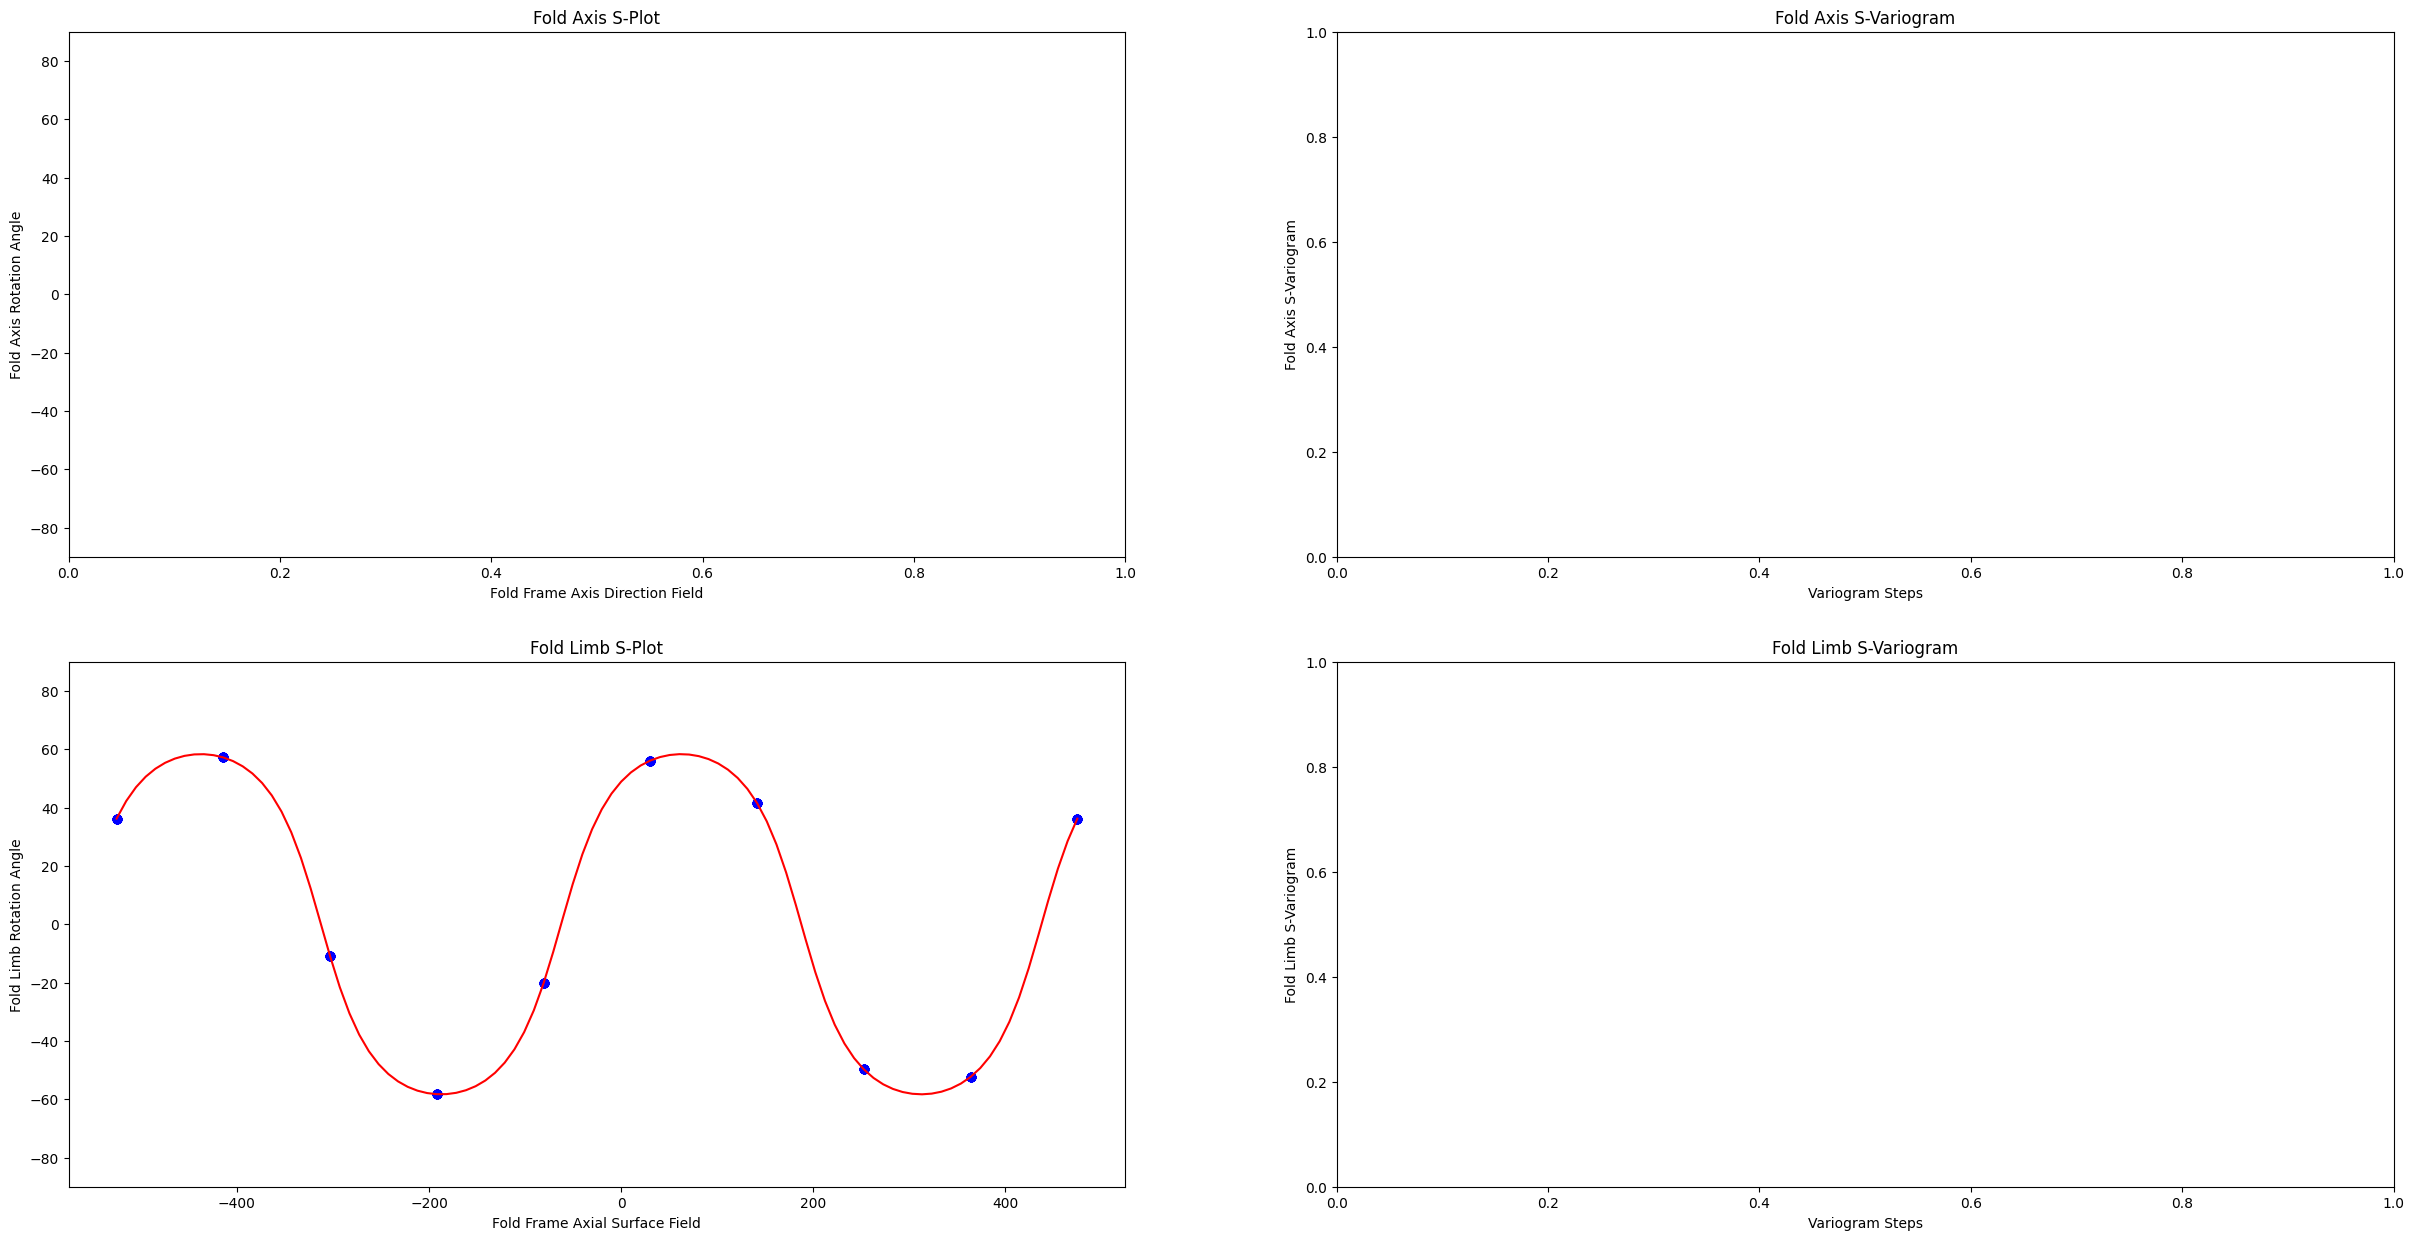

In [12]:
s0.set_model(model)
plotter = RotationAnglePlotter(s0)
plotter.default_titles()
plotter.add_fold_limb_data()
plotter.add_fold_limb_curve()
# plotter.add_limb_svariogram()
plt.show()

- Visualise the 3D model of s0

In [13]:
# viewer = LavaVuModelViewer(model, background='white')
# viewer.nsteps = np.array([100, 100, 100])
# t = viewer.add_scalar_field(s0, cmap='prism')
# # viewer.lv.colourbar(t, align=("bottom"))
# viewer.lv.rotate([-63.015506744384766, -24.475210189819336, -8.501092910766602])
# viewer.display()
# viewer.interactive()

# II. Axial surface optimisation

- **write a brief intro of what will happen in this section**

###### **1. Sampling S<sub>0</sub> from the reference model**  


In [14]:
# generate random locations within the model bouding box
points = sample_random_dataset(xyz, sample_size=10, seed=180)
# Evaluate the gradient of the folded foliation using points 
s0g = s0.evaluate_gradient(points) 
# normalise the gradient 
s0g /= np.linalg.norm(s0g, axis=1)[:, None] 

In [15]:
test_data = pd.DataFrame()
test_data['X'] = points[:, 0]
test_data['Y'] = points[:, 1]
test_data['Z'] = points[:, 2]
test_data['gx'] = s0g[:, 0]
test_data['gy'] = s0g[:, 1]
test_data['gz'] = s0g[:, 2]
test_data['feature_name'] = 's0'
test_data['coord'] = 0

In [16]:
aso = ASO(test_data, 
          bounding_box, 
          method='differential_evolution', 
          axial_surface_guess=[0, 90], 
          av_fold_axis=True
         )

In [18]:
results = aso.optimise()

  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:25:18,427: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:25:20,026: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:25:21,503: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:25:22,852: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:25:24,206: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:25:25,623: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:25:27,106: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:25:28,611: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:25:30,107: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:25:31,610: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:25:32,959: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:25:34,507: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:25:35,897: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:25:37,279: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:25:38,724: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:25:40,180: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:25:41,390: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:25:42,702: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:25:44,102: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:25:45,565: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:25:47,471: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:26:01,744: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:26:03,271: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:26:04,881: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:26:06,850: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:26:11,977: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:26:13,837: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:26:15,540: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:26:17,442: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:26:19,125: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:26:21,544: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:26:23,988: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:26:26,897: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:26:35,141: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:26:37,846: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:26:40,006: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:26:42,152: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:26:44,107: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:26:46,136: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:26:50,159: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:26:52,441: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:26:54,265: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:26:56,082: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:26:58,289: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:27:00,501: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:27:02,388: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:27:04,332: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:27:06,109: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:27:10,504: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:27:13,660: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:27:15,516: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:27:17,246: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:27:20,599: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:27:24,002: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:27:25,816: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:27:29,006: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:27:37,136: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:27:39,048: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:27:44,030: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:27:45,663: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:27:47,683: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:27:49,459: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:27:54,275: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:27:56,131: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:27:57,914: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:27:59,656: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:28:01,550: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:28:03,225: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:28:04,790: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:28:06,547: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:28:08,493: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:28:10,201: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:28:11,888: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:28:13,595: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:28:15,557: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:28:18,177: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:28:24,277: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:28:28,239: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:28:29,952: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:28:31,787: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:28:34,630: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:28:38,313: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:28:40,045: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:28:41,910: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:28:44,394: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:28:46,545: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:28:48,465: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:28:50,275: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:28:52,369: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:28:54,132: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:28:56,086: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:28:59,788: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:29:02,595: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:29:05,984: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:29:08,134: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:29:09,959: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:29:11,715: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:29:13,313: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:29:15,136: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:29:17,162: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:29:18,937: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:29:20,657: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:29:22,532: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:29:28,775: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:29:30,807: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:29:32,648: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:29:34,481: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:29:36,229: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:29:38,570: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:29:40,220: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:29:41,921: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:29:43,753: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:29:45,369: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:29:47,177: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:29:49,502: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:29:51,223: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:29:53,028: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:29:54,868: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:29:56,589: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:29:58,378: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:30:03,960: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:30:05,761: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:30:07,496: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:30:09,469: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:30:11,324: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:30:14,428: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:30:17,009: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:30:18,744: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:30:20,604: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:30:22,336: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:30:24,128: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:30:25,994: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:30:27,943: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:30:29,621: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:30:31,514: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:30:33,410: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:30:35,743: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:30:40,004: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:30:42,758: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:30:44,933: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:30:47,682: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:30:49,877: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:30:52,266: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:30:54,346: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:30:56,406: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:30:58,433: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:31:00,748: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:31:03,072: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:31:06,371: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:31:08,621: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:31:10,747: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:31:12,743: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:31:14,781: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:31:17,437: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:31:20,554: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:31:22,745: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:31:25,038: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:31:29,157: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:31:31,064: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:31:32,882: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:31:35,022: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:31:36,943: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:31:39,424: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:31:42,318: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:31:44,594: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:31:46,542: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:31:48,308: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:31:50,148: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:31:51,884: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:31:53,624: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:31:55,366: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:31:57,424: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:31:59,006: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:32:03,875: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:32:05,638: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:32:07,440: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:32:09,203: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:32:10,922: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:32:12,747: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:32:14,494: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:32:16,359: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:32:18,084: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:32:20,001: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:32:23,725: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:32:25,352: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:32:27,487: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:32:29,287: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:32:31,142: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:32:33,059: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:32:34,677: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:32:36,363: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:32:38,158: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:32:39,811: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:32:41,829: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:32:43,664: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:32:45,486: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:32:47,299: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:32:49,104: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:32:50,741: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:32:52,374: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:32:54,101: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:32:55,929: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:32:57,940: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:32:59,464: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:33:01,068: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:33:02,891: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:33:04,568: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:33:06,537: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:33:08,264: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:33:10,277: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:33:12,048: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:33:13,856: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:33:15,753: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:33:18,932: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:33:20,579: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:33:22,248: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:33:24,041: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:33:25,976: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:33:27,638: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:33:29,395: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:33:31,151: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:33:33,160: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:33:34,835: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:33:36,447: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:33:38,202: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:33:40,068: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:33:41,872: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:33:43,795: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:33:45,691: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:33:47,451: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:33:49,084: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:33:51,161: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:33:53,002: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:33:54,800: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:33:56,605: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:33:58,628: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:34:00,258: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:34:02,342: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:34:04,042: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:34:05,688: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:34:07,369: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:34:09,092: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:34:10,871: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:34:13,167: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:34:14,837: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:34:18,816: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:34:20,617: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:34:22,273: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:34:25,661: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:34:27,302: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:34:28,974: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:34:30,696: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:34:32,552: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:34:34,371: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:34:36,290: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:34:38,095: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:34:40,004: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:34:41,721: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:34:43,543: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-26 11:34:45,374: _geological_feature_builder.py:266 -- Not enough constraints for scalar field add more


In [19]:
print('Axial surface optimisation results: ')
print('strike: ', results.x[0])
print('dip: ', results.x[1])

Axial surface optimisation results: 
strike:  0.0
dip:  89.98438264271815
